# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Lines finding on the Road** 

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1. Compute the camera calibration using chessboard images

**Import Packages**

In [1]:
#importing some useful packages
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

**Find chessboard corners**

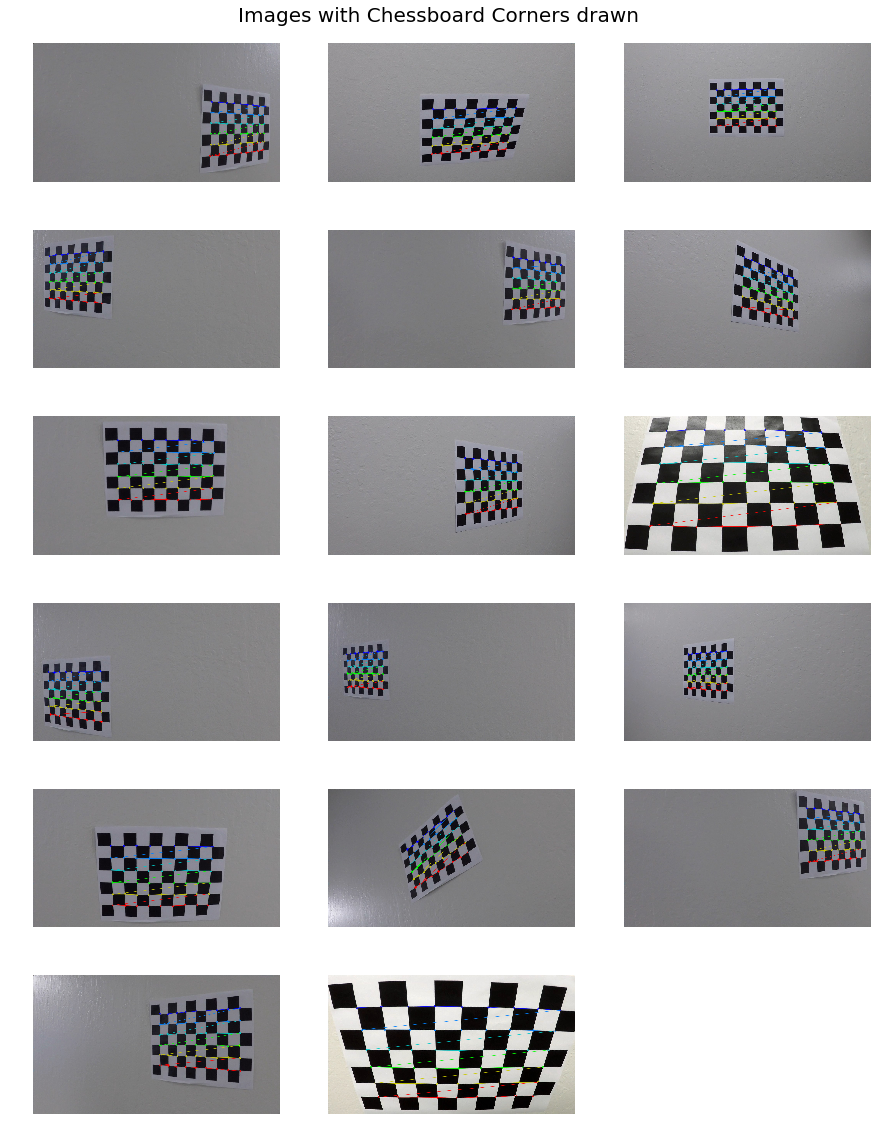

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
x_cor = 9
y_cor = 6
objp = np.zeros((y_cor*x_cor,3), np.float32)
objp[:,:2] = np.mgrid[0:x_cor,0:y_cor].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

plt.figure(figsize=(15, 20))
# Step through the list and search for chessboard corners
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (x_cor,y_cor),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (x_cor,y_cor), corners, ret)
        plt.subplot(6, 3, len(imgpoints)) # Instead of using (i+1) as always, because that gives empty spaces when the "if" condition not satisfied 
        plt.imshow(img)
        plt.axis('off')
        plt.suptitle("Images with Chessboard Corners drawn", fontsize=20, y=0.9)


## 2. Apply a distortion correction to raw images

In [3]:
# Save it as a pickle file
import pickle
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

mtx_dist_dict = {"mtx": mtx, "dist": dist}
pickle.dump(mtx_dist_dict, open("wide_dist_pickle.p", "wb"))

**Display some images**

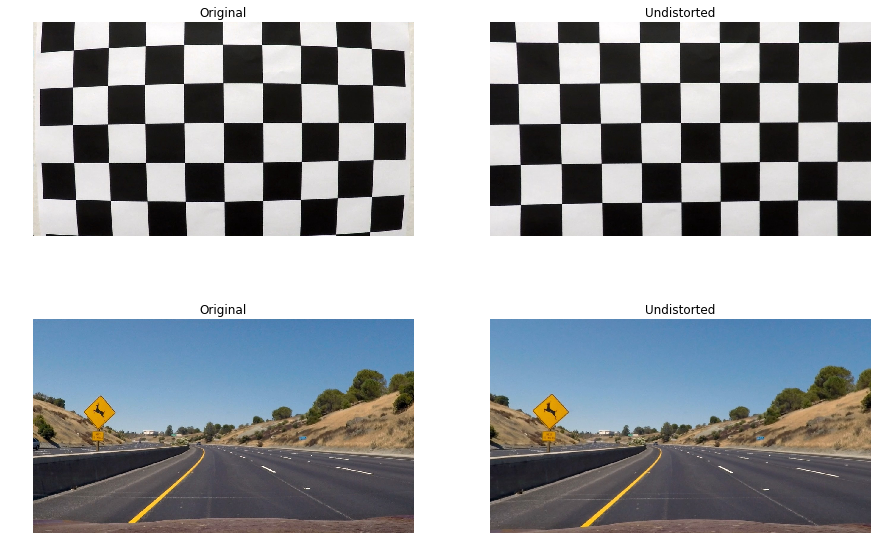

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))
axes = axes.ravel()

a = mpimg.imread("camera_cal/calibration1.jpg")
b = mpimg.imread("test_images/test2.jpg")

axes[0].axis('off')
axes[0].imshow(a)
axes[0].set_title("Original")
axes[1].axis('off')
axes[1].imshow(undistort(a))
axes[1].set_title("Undistorted")
axes[2].axis('off')
axes[2].imshow(b)
axes[2].set_title("Original")
axes[3].axis('off')
axes[3].imshow(undistort(b))
axes[3].set_title("Undistorted")
fig.savefig('output_images/undistorted_output.jpg')

## 3. Use color transforms, gradients, etc., to create a thresholded binary image

In [5]:
# All the images read using mpimg.imread()
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, abs_thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y' and their absolute values
    if orient=='x':
        sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    else:
        sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    # 3) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # 4) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    thresh_min, thresh_max = abs_thresh
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 5) Return this mask as binary_output image
    return gray, sxbinary


def mag_sobel_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    thresh_min, thresh_max = mag_thresh
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as binary_output image
    return gray, sxbinary


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately and their absolute values
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
    # 3) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    scaled_sobel = np.arctan2(sobely, sobelx)
    # 4) Create a binary mask where direction thresholds are met
    thresh_min, thresh_max = thresh
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 5) Return this mask as your binary_output image
    return gray, sxbinary


def hls_select(img, selection="h", thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the channel selected
    if selection=="h":
        select = hls[:,:,0]
    elif selection=="l":
        select = hls[:,:,1]
    else:
        select = hls[:,:,2]
    binary = np.zeros_like(select)
    binary[(select > thresh[0]) & (select <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return select, binary

def rgb_select(img, selection="r", thresh=(0, 255)):
    # 1) Apply a threshold to the channel selected
    if selection=="r":
        select = img[:,:,0]
    elif selection=="g":
        select = img[:,:,1]
    else:
        select = img[:,:,2]
    binary = np.zeros_like(select)
    binary[(select > thresh[0]) & (select <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return select, binary

def hsv_select(img, selection="h", thresh=(0, 255)):
    # 1) Convert to HLS color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # 2) Apply a threshold to the channel selected
    if selection=="h":
        select = hsv[:,:,0]
    elif selection=="s":
        select = hsv[:,:,1]
    else:
        select = hsv[:,:,2]
    binary = np.zeros_like(select)
    binary[(select > thresh[0]) & (select <= thresh[1])] = 1
    
    # 3) Return a binary image of threshold result
    return select, binary

**Visualize seperate Channels**

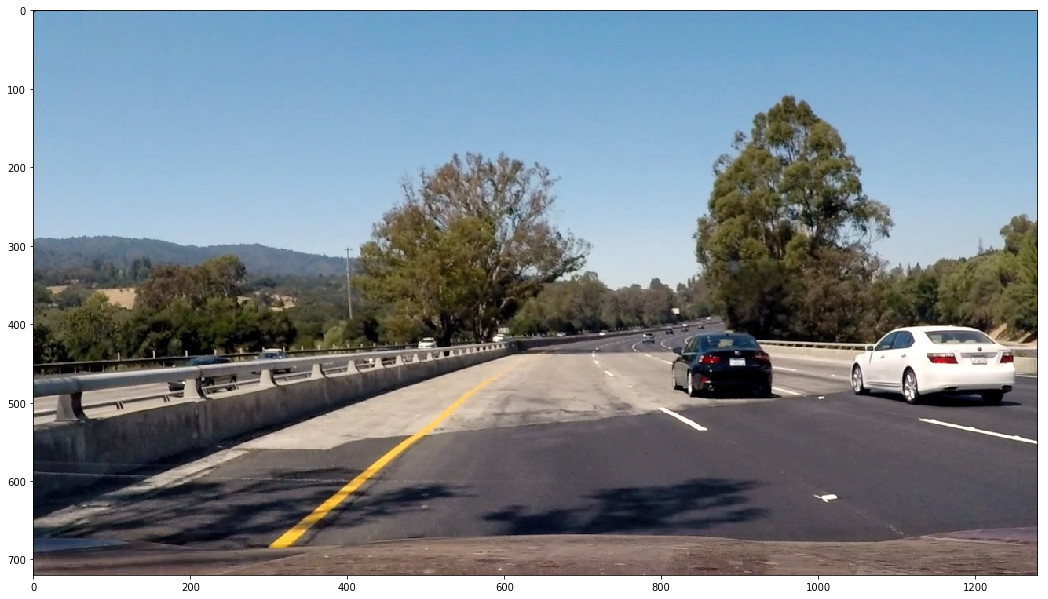

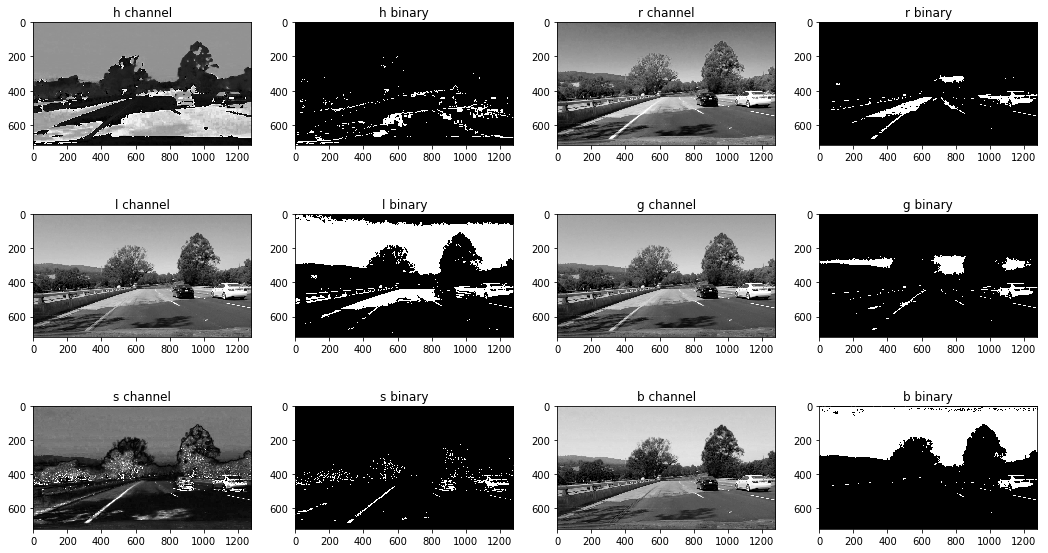

In [6]:
# Perform the operation for all the images in the "test_images/" folder
import glob
image_names = glob.glob("test_images/*.jpg")

test_img = mpimg.imread(image_names[1])
plt.figure(figsize=(18,12))
plt.imshow(test_img)

# show seperate channels for this image
# test_img_h, _ = hls_select(test_img, selection="h")
# test_img_l, _ = hls_select(test_img, selection="l")
# test_img_s, _ = hls_select(test_img, selection="s")

fig, axes = plt.subplots(3, 4, figsize=(18,10))
axes = axes.ravel()

for i, selection in enumerate(["h","l","s"]):
    test_img_hls, test_img_binary_hls = hls_select(test_img, selection=selection, thresh=(160, 255))
    axes[i*4].imshow(test_img_hls, cmap="gray")
    axes[i*4].set_title(selection + " channel")
    axes[i*4+1].imshow(test_img_binary_hls, cmap="gray")
    axes[i*4+1].set_title(selection + " binary")

for i, selection in enumerate(["r","g","b"]):
    test_img_rgb, test_img_binary_rgb = rgb_select(test_img, selection=selection, thresh=(200, 255))
    axes[i*4+2].imshow(test_img_rgb, cmap="gray")
    axes[i*4+2].set_title(selection + " channel")
    axes[i*4+3].imshow(test_img_binary_rgb, cmap="gray")
    axes[i*4+3].set_title(selection + " binary")


fig.savefig('output_images/color_transformed.jpg')

**Visualize Sobel images**

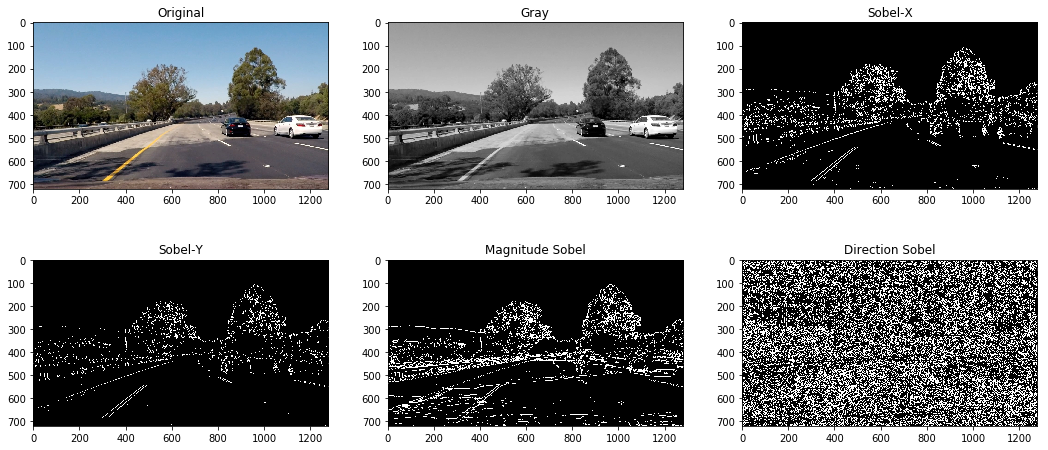

In [7]:
test_img_gray, sobelx = abs_sobel_thresh(test_img, orient='x', sobel_kernel=3, abs_thresh=(20, 150))
_, sobely = abs_sobel_thresh(test_img, orient='y', sobel_kernel=3, abs_thresh=(30, 100))
_, mag_sobel = mag_sobel_thresh(test_img, sobel_kernel=3, mag_thresh=(30, 100))
_, dir_sobel = dir_threshold(test_img, sobel_kernel=3, thresh=(40*np.pi/180, 75*np.pi/180))


fig, axes = plt.subplots(2, 3, figsize=(18,8))
axes = axes.ravel()

axes[0].imshow(test_img)
axes[0].set_title("Original")
axes[1].imshow(test_img_gray, cmap="gray")
axes[1].set_title("Gray")
axes[2].imshow(sobelx, cmap="gray")
axes[2].set_title("Sobel-X")
axes[3].imshow(sobely, cmap="gray")
axes[3].set_title("Sobel-Y")
axes[4].imshow(mag_sobel, cmap="gray")
axes[4].set_title("Magnitude Sobel")
axes[5].imshow(dir_sobel, cmap="gray")
axes[5].set_title("Direction Sobel")
fig.savefig('output_images/sobelOutputs.jpg')

In [8]:
def gaussian_blur(img):
    """Applies a Gaussian Noise kernel"""
    kernel_size = 5
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# test_img = mpimg.imread("test_images/test5.jpg")
# brighten_test_img = gaussian_blur(test_img)
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
# f.tight_layout()

# ax1.imshow(test_img)
# ax1.set_title('Original Image', fontsize=20)
# ax2.imshow(brighten_test_img, cmap="gray")
# ax2.set_title('Brightened', fontsize=20)

**Get combined binary image**

In [38]:
def select_yellow(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower = np.array([20,60,60])
    upper = np.array([38,174, 250])
    mask = cv2.inRange(hsv, lower, upper)
    return mask


def select_white(img):
    lower = np.array([202,202,202])
    upper = np.array([255,255,255])
    mask = cv2.inRange(img, lower, upper)
    return mask

def combined_thresh(img, use_sobel=False, s_thresh=(140, 255), rgb_thresh=(210, 255), sobelx_thresh=(2, 50), sobely_thresh=(20, 100), hsv_thresh=(215,255), mag_thresh=(1, 150)):
    s, s_binary = hls_select(img, "s", s_thresh)
    r, r_binary = rgb_select(img, "r", rgb_thresh)
    g, g_binary = rgb_select(img, "g", rgb_thresh)
    v, v_binary = hsv_select(img, "v", hsv_thresh)
    
    _, sxbinary = abs_sobel_thresh(img, orient='x', sobel_kernel=5, abs_thresh=sobelx_thresh)
    _, sybinary = abs_sobel_thresh(img, orient='y', sobel_kernel=5, abs_thresh=sobely_thresh)
    _, mag_binary = mag_sobel_thresh(img, sobel_kernel=3, mag_thresh=mag_thresh)
    
    yellow_binary = select_yellow(img)
    white_binary = select_white(img)
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), s_binary, r_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    if (use_sobel):
        combined_binary[(r_binary==1) | ((v_binary==1) & (s_binary==1)) | (sxbinary==1) | (sybinary==1) | (yellow_binary==1) | (white_binary==1)] = 1 
    else:
        combined_binary[(r_binary==1) | ((v_binary==1) & (s_binary==1))] = 1

    return color_binary, combined_binary


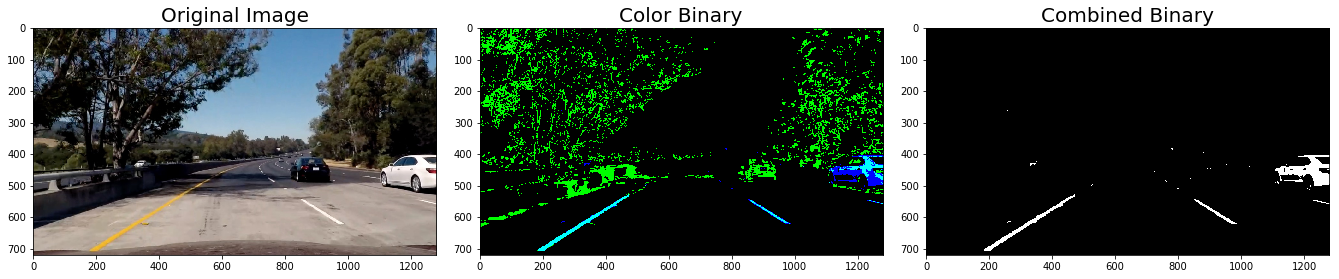

In [10]:
test_img = mpimg.imread("test_images/test5.jpg")
test_img = undistort(test_img)
color_binary, combined_binary = combined_thresh(test_img, use_sobel=False) # input to combined_thresh is undistorted image
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 8))
f.tight_layout()

ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(color_binary, cmap="gray")
ax2.set_title('Color Binary', fontsize=20)
ax3.imshow(combined_binary, cmap="gray")
ax3.set_title('Combined Binary', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig('output_images/combinedBinary.jpg')




## 4. Apply Percpective Transform and warp the images

**Get dist and mtx from pickled data**

In [11]:
dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

In [12]:
def corners_unwarp(img): # img is undistorted image
    nx, ny = x_cor, y_cor
    img_size = (img.shape[1], img.shape[0])
    # 2) Get src and dst points
    src = np.float32([[585, 460],
    [210, img_size[1]],
    [1130, img_size[1]],
    [700, 460]])
    dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
    # 3) Get matrices to warp and unwarp
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # 4) Warp the image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv, src, dst

**Visualize some Images**

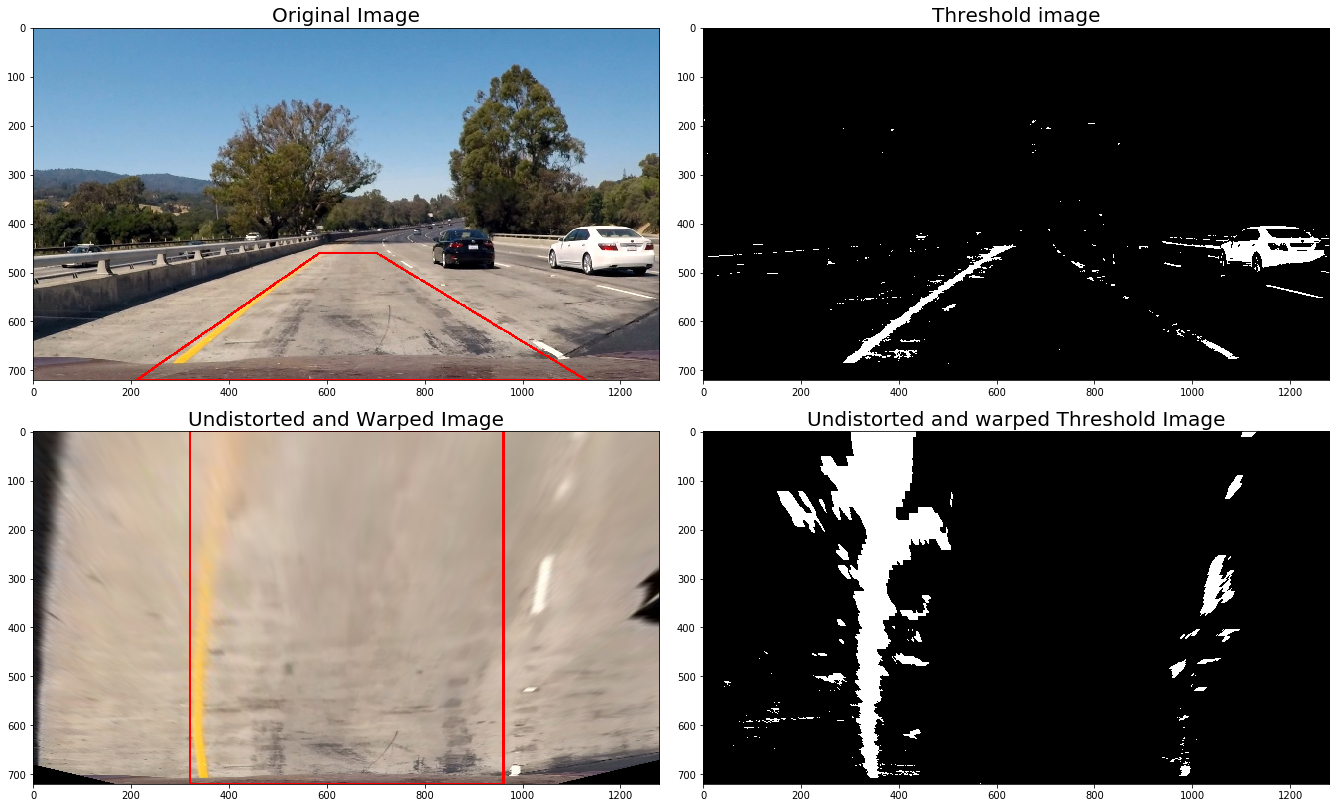

In [13]:
test_img = mpimg.imread("test_images/test1.jpg")
_, thresh_img = combined_thresh(test_img, use_sobel=False)
top_down, M, Minv, src, dst = corners_unwarp(test_img)
top_down_thresh, _, _, _, _ = corners_unwarp(thresh_img)

cv2.polylines(test_img, np.int32([src]), isClosed = True, color=[255, 0, 0], thickness=3) 
cv2.polylines(top_down, np.int32([dst]), isClosed = True, color=[255, 0, 0], thickness=3) 


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(thresh_img, cmap="gray")
ax2.set_title('Threshold image', fontsize=20)
ax3.imshow(top_down)
ax3.set_title('Undistorted and Warped Image', fontsize=20)
ax4.imshow(top_down_thresh, cmap="gray")
ax4.set_title('Undistorted and warped Threshold Image', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig('output_images/perceptiveImageOutputs.jpg')

## 5. Detect lane pixels and fit to find the lane boundary

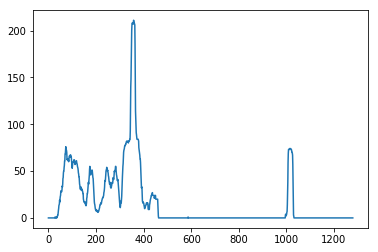

In [14]:
def img_to_warped(img, use_sobel=False): #undistorted image inputted
    _, thresh_img = combined_thresh(img, use_sobel=use_sobel)
    binary_warped, _, _, _, _ = corners_unwarp(thresh_img)
    return binary_warped

def plot_hist(binary_warped):
    # Histogram of peaks
    histogram = np.sum(binary_warped[binary_warped.shape[0]*2//3:,:], axis=0) 
    plt.plot(histogram)

test_img = mpimg.imread("test_images/test4.jpg")
binary_warped = img_to_warped(test_img)
plot_hist(binary_warped)

In [15]:
def lane_boundaries(binary_warped, nwindows=9):
    # Histogram of peaks
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0) # Checking histogram for 2/3rd of img
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,255), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,255), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    out_img[lefty, nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return leftx, lefty, rightx, righty, out_img
    

# Fit a quadratic polynomial
def fit_quadratic(binary_warped):
    leftx, lefty, rightx, righty, out_img = lane_boundaries(binary_warped)
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fitx, right_fitx, ploty, out_img

def plot_lanes(img):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 8))
    # Retreive the binary warped image
    binary_warped = img_to_warped(img)
    
    left_fitx, right_fitx, ploty, out_img = fit_quadratic(binary_warped)
    
    [i.axis("off") for i in (ax1, ax2, ax3)]
    ax1.imshow(img)
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(binary_warped, cmap="gray")
    ax2.set_title('Warped', fontsize=20)
    ax3.imshow(out_img)
    ax3.plot(left_fitx, ploty, color='yellow')
    ax3.plot(right_fitx, ploty, color='orange')
    ax3.set_title('Fitted Image', fontsize=20)
    f.savefig('output_images/binaryWarped.jpg')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

**Check it on a test image**

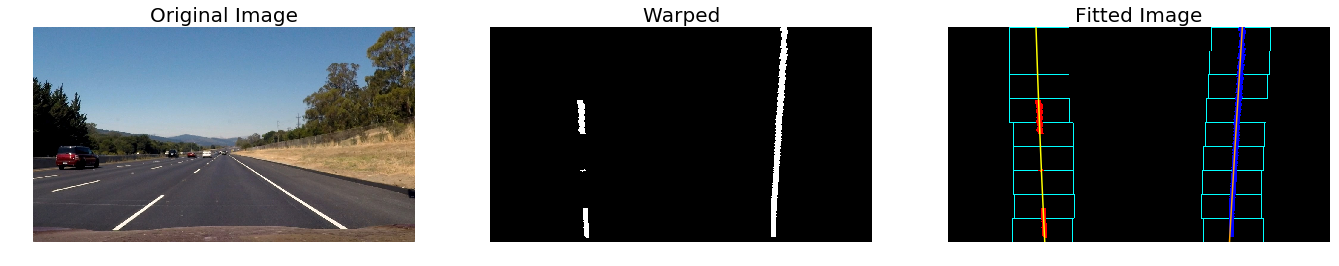

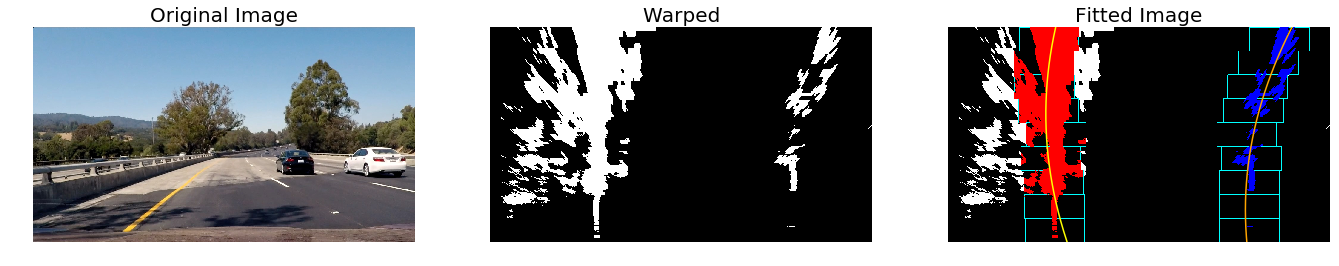

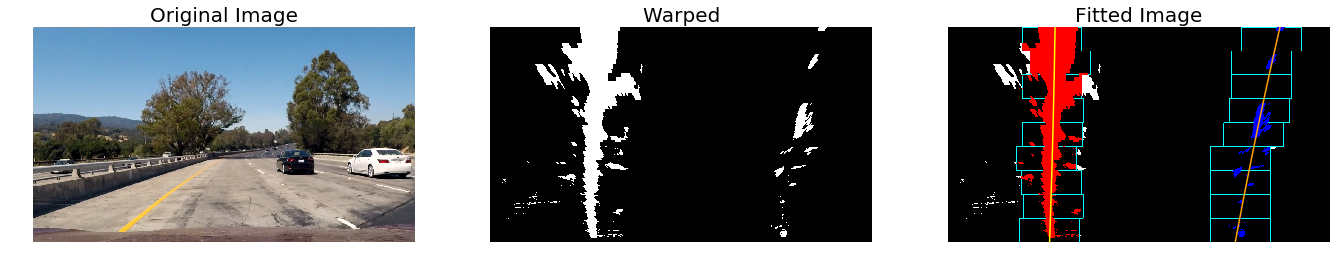

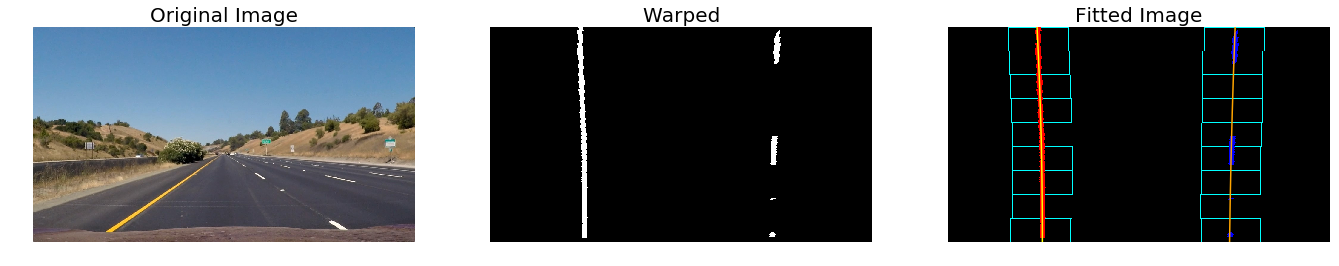

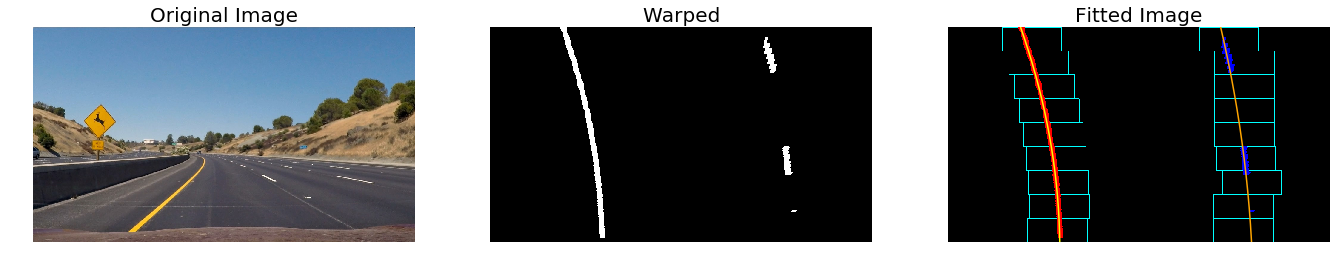

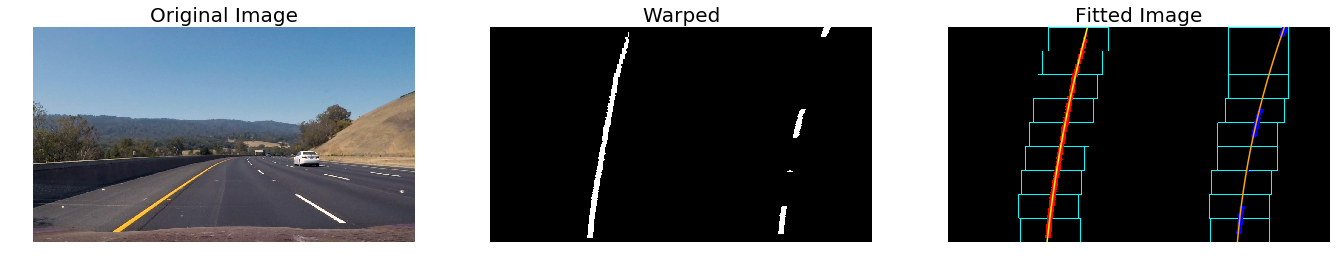

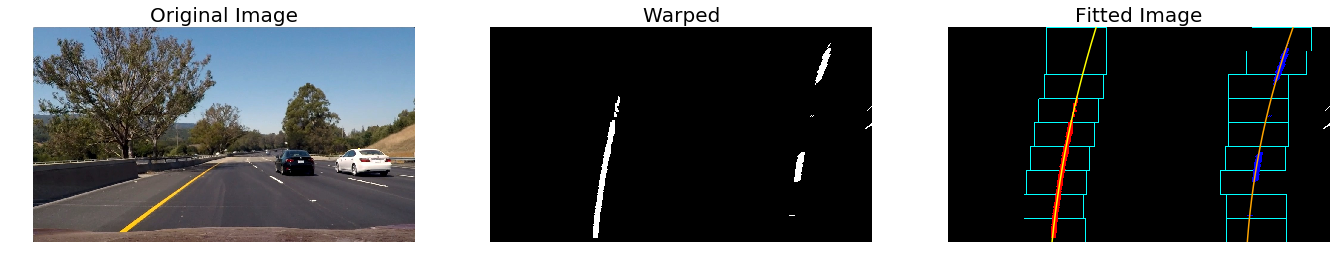

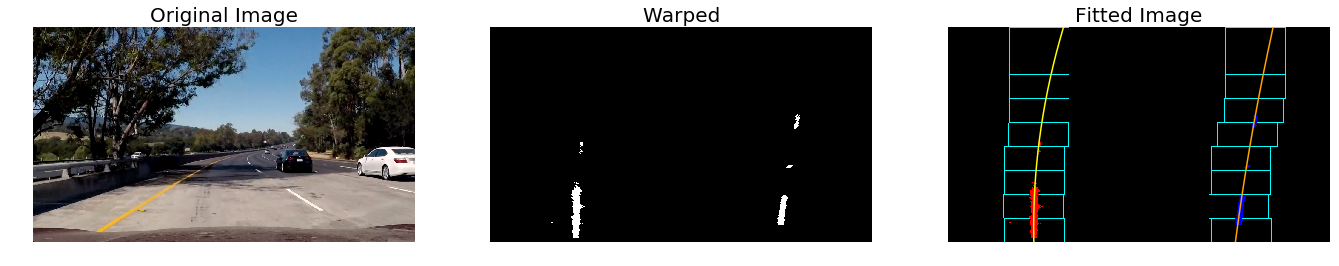

In [16]:
test_image_names = glob.glob("test_images/*.jpg")
for fname in test_image_names:
    test_img = mpimg.imread(fname)
    plot_lanes(test_img)

## 6. Determine the curvature of the lane and vehicle position with respect to center

In [17]:
def curvature_cal(binary_warped):
    leftx, lefty, rightx, righty, _ = lane_boundaries(binary_warped)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)

    left_fitx, right_fitx, ploty, out_img = fit_quadratic(binary_warped)
    width = right_fitx - left_fitx
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/np.mean(width) # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Calculating the offset
    ht = binary_warped.shape[0] * ym_per_pix
    car_center = binary_warped.shape[1]/2 * xm_per_pix
    left_intercept = left_fit_cr[0] * ht ** 2 + left_fit_cr[1] * ht + left_fit_cr[2]
    right_intercept = right_fit_cr[0] * ht ** 2 + right_fit_cr[1] * ht + right_fit_cr[2]
    calculated_center = (left_intercept + right_intercept) / 2.0
    vechicle_offset = calculated_center - car_center

    return left_curverad, right_curverad, vechicle_offset

**Print these values on a test image**

In [18]:
test_img = mpimg.imread("test_images/test5.jpg")
left_curverad, right_curverad, vechicle_offset = curvature_cal(img_to_warped(test_img))  
print(left_curverad, right_curverad, vechicle_offset)

744.827937579 2701.96925821 -0.0709001376608


## 7. Warp the detected lane boundaries back onto the original image

In [19]:
def warp_to_original(img, left_fitx, right_fitx, ploty):
    # Undistort first
    img = undistort(img)
    # Get the binary
    binary_warped = img_to_warped(img)
    _, M, Minv, src, dst = corners_unwarp(img)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

## 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

In [20]:
def add_text(img):
    binary_warped = img_to_warped(img)
    left_curverad, right_curverad, vechicle_offset = curvature_cal(binary_warped)
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(img,'Left radius of curvature  = %.2f m'%(left_curverad), (50,50), font, 1, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(img,'Right radius of curvature = %.2f m'%(right_curverad), (50,80), font, 1, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(img,'Vehicle position : %.2f m %s from center'%(abs(vechicle_offset), 'left' if vechicle_offset < 0 else 'right'), (50,120), font, 1, (255,255,255), 2, cv2.LINE_AA)
    return img

**Test on an image**

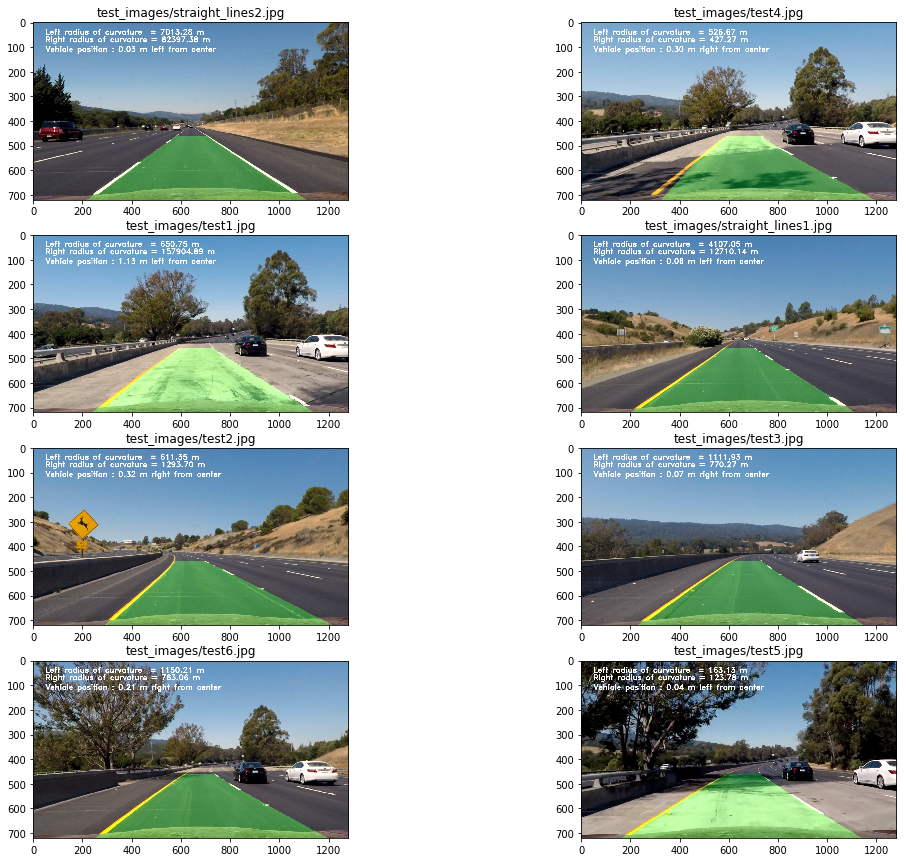

In [21]:
# Make a list of calibration images
images = glob.glob('test_images/*.jpg')
fig, axes = plt.subplots(4, 2, figsize=(18,15))
axes = axes.ravel()
for i, fname in enumerate(images):
    img = mpimg.imread(fname) # Read the test images
    binary_warped = img_to_warped(img)
    left_fitx, right_fitx, ploty, out_img = fit_quadratic(binary_warped)
    final_img = add_text(warp_to_original(img, left_fitx, right_fitx, ploty))
    axes[i].imshow(final_img)
    axes[i].set_title(fname)
fig.savefig('output_images/finalOutputImages.jpg')

## Test on Videos

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

In [23]:
def video_continuity(binary_warped):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    leftx, lefty, rightx, righty, out_img = lane_boundaries(binary_warped)
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx, right_fitx, out_img, ploty # Keeping a similar output format as "fit_quadratic" function

In [39]:
t = 0
def video_pipeline(img, use_sobel=True):
    _, thresh_img = combined_thresh(img, use_sobel=use_sobel)
    binary_warped, _, _, _, _ = corners_unwarp(thresh_img)
    global t
    if (t==0):
        left_fitx, right_fitx, ploty, out_img = fit_quadratic(binary_warped)
        t = 1
    else: # Not first instance
        left_fitx, right_fitx, out_img, ploty = video_continuity(binary_warped)
        t = 2

    final_img = add_text(warp_to_original(img, left_fitx, right_fitx, ploty))
    return final_img

In [25]:
# Create output directory if it doesn't exist
if not os.path.exists("test_videos_output"):
    os.makedirs("test_videos_output")
white_output = 'test_videos_output/ProjectVideoOutput.mp4'

##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(video_pipeline)
%time white_clip.write_videofile(white_output, audio=False)    


[MoviePy] >>>> Building video test_videos_output/ProjectVideoOutput.mp4
[MoviePy] Writing video test_videos_output/ProjectVideoOutput.mp4


100%|█████████▉| 1260/1261 [07:34<00:00,  2.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/ProjectVideoOutput.mp4 

CPU times: user 39min 19s, sys: 4.58 s, total: 39min 23s
Wall time: 7min 35s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))